In [ ]:
!git clone https://github.com/catInOrbit/LFS_Datasets.git

Cloning into 'LFS_Datasets'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 11 (delta 2), reused 11 (delta 2), pack-reused 0
Unpacking objects: 100% (11/11), done.


In [ ]:
!sudo apt-get install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 0s (18.7 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package git-lfs.
(Reading database ... 155225 files and directories cu

In [ ]:
%cd /content/LFS_Datasets
!git lfs install
!git checkout .
!git lfs fetch
!git lfs pull

/content/LFS_Datasets
Updated git hooks.
Git LFS initialized.
Fetching main
Git LFS: (2 of 2 files) 178.92 MB / 178.92 MB


**Path Constants**

In [ ]:
# import os

# PROJECT_ROOT = os.path.dirname(__file__)
# ENCODER_PATH = os.path.join(PROJECT_ROOT, 'encoder.pkl')
# MODEL_PATH = os.path.join(PROJECT_ROOT, 'model_saved_multi')
# MODEL_WEIGHTS_PATH = os.path.join(PROJECT_ROOT, 'model_weights_multi/weights.h5')

NameError: ignored

**Preprocessing**

In [ ]:
import pandas as pd

def load_dataframe(json_filePath):
    dataframe = pd.read_json(json_filePath, lines=True)
    dataframe = dataframe.loc[:, ["overall", "reviewText"]]
    dataframe.dropna(inplace=True)
    print(dataframe.describe())
    print(dataframe.info())
    return dataframe

**Model**

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense
from tensorflow.keras import Sequential

def model_creation(vocab_size, embedding_dim, embedding_matrix,
                   rnn_units,
                   train_embed=False):
    model = Sequential(
        [
            Embedding(vocab_size, embedding_dim,
                      weights=[embedding_matrix], trainable=train_embed, mask_zero=True),
            Bidirectional(LSTM(rnn_units, return_sequences=True, dropout=0.5)),
            Bidirectional(LSTM(rnn_units, dropout=0.25)),
            Dense(1, activation="sigmoid")
        ])

    return model

**Encoding**

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import sequence
import tensorflow as tf

def encode_pad_transform(encoder, sample):
    encoded = encoder.encode(sample.numpy())
    pad = sequence.pad_sequences([encoded], padding='post',
                             maxlen=150)
    return np.array(pad[0], dtype=np.int64)

def encode_tf_fn(sample, label):
    encoded = tf.py_function(encode_pad_transform,
                             inp=[sample],
                             Tout=(tf.int64))
    encoded.set_shape([None])
    return encoded, label

**Glove Emebedding**

In [ ]:
import numpy as np
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense
from tensorflow.keras import Sequential
import tensorflow as tf
def load_glove(glove_txt_file):
    dict_w2v = {} # dictionary
    with open(glove_txt_file, 'r') as file:
        for line in file:
            tokens = line.split()
            word = tokens[0]
            vector = np.array(tokens[1:], dtype=np.float32)

            if vector.shape[0] == 50:
                dict_w2v[word] = vector
            else:
                print("There was an issue with ", word)
    print("Glove loaded with dictionary size: ", len(dict_w2v))

    return dict_w2v

def create_embedding_matrix(encoder,dict_w2v):
    embedding_dim = 50
    embedding_matrix = np.zeros((encoder.vocab_size, embedding_dim))

    unknown_count = 0
    unknown_set = set()
    for word in encoder.tokens:
        embedding_vector =  dict_w2v.get(word)

        if embedding_vector is not None: # dictionary contains word
            # test = encoder.encode(word)
            token_id = encoder.encode(word)[0]
            embedding_matrix[token_id] = embedding_vector
        else:
            unknown_count += 1
            unknown_set.add(word)
    print(embedding_matrix.shape)
    print("Embedding matrix created with total unknown words: ", unknown_count)
    return embedding_matrix

def model_creation(vocab_size, embedding_dim, embedding_matrix,
                   rnn_units, batch_size,
                   train_embed=False):
    model = Sequential(
        [
            Embedding(vocab_size, embedding_dim,
                      weights=[embedding_matrix], trainable=train_embed, mask_zero=True),
            Bidirectional(LSTM(rnn_units, return_sequences=True, dropout=0.5)),
            Bidirectional(LSTM(rnn_units, dropout=0.25)),
            Dense(5, activation="softmax")
        ])

    dot_img_file = 'model_1.png'
    tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

    return model

**Feature Engineering**

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import sequence
import tensorflow as tf
import tensorflow_datasets as tfds
import pickle


class FeatureEngineering():
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def convert_to_tfds(self):
        overall_ohc = pd.get_dummies(self.dataframe.overall)
        reviewText = self.dataframe.reviewText.values
        dataset = tf.data.Dataset.from_tensor_slices((reviewText, overall_ohc))
        return dataset

    def tokenizing(self,  dataset):
        vocabulary_set = set()
        tokenizer = tfds.deprecated.text.Tokenizer()
        MAX_TOKENS = 0

        for reviewText, overall in dataset:
            some_tokens = tokenizer.tokenize(reviewText.numpy())
            if MAX_TOKENS < len(some_tokens):
                MAX_TOKENS = len(some_tokens)
            vocabulary_set.update(some_tokens)

        encoder = tfds.deprecated.text.TokenTextEncoder(vocabulary_set,
                                                        lowercase=True,
                                                        tokenizer=tokenizer)
        return encoder


class Encoding():
    def __init__(self, encoder):
        self.encoder = encoder

    def __encode_pad_transform(self, sample):
        encoded = self.encoder.encode(sample.numpy())
        pad = sequence.pad_sequences([encoded], padding='post',
                                     maxlen=150)
        return np.array(pad[0], dtype=np.int64)

    def encode_tf_fn(self, sample, label):
        encoded = tf.py_function(self.__encode_pad_transform,
                                 inp=[sample],
                                 Tout=(tf.int64))
        encoded.set_shape([None])
        return encoded, label

**Plotting Module**

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_acc(model_history):
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


**Training**

            overall
count  12804.000000
mean       3.877773
std        1.362103
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12804 entries, 0 to 12804
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   overall     12804 non-null  int64 
 1   reviewText  12804 non-null  object
dtypes: int64(1), object(1)
memory usage: 300.1+ KB
None
Vocab size:  35210
Glove loaded with dictionary size:  400000
(35210, 50)
Embedding matrix created with total unknown words:  5272
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 50)          1760500   
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 256)        183296    
 nal)       

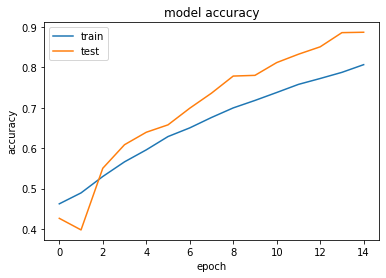

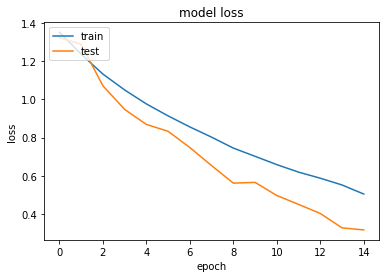

In [ ]:
import os
import tensorflow as tf

df_sentiment = load_dataframe("/content/LFS_Datasets/Software_5.json")
feature_engineering = FeatureEngineering(df_sentiment)
DATASET_SIZE = df_sentiment.size

dataset = feature_engineering.convert_to_tfds()
encoder = feature_engineering.tokenizing(dataset)

# with open(definition.ENCODER_PATH, 'wb') as encoder_file:
#     pickle.dump(encoder, encoder_file, protocol=pickle.HIGHEST_PROTOCOL)


vocab_size = encoder.vocab_size
print("Vocab size: ", vocab_size)

train_data = dataset.take(int(0.8 * DATASET_SIZE))
test_data = dataset.take(int(0.2 * DATASET_SIZE))

ec = Encoding(encoder)
encoded_train = train_data.map(ec.encode_tf_fn,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)
encoded_test = test_data.map(ec.encode_tf_fn,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)

dict_w2v = load_glove('/content/LFS_Datasets/glove.6B.50d.txt')

embedding_matrix = create_embedding_matrix(encoder, dict_w2v)

rnn_units = 128
BATCH_SIZE = 50

model_fine_tuning = model_creation(
    vocab_size = vocab_size,
    embedding_matrix= embedding_matrix,
    embedding_dim=50,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE,
    train_embed=True
)

print(model_fine_tuning.summary())

model_fine_tuning.compile(loss='categorical_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy', 'Precision', 'Recall'])
encoded_train_batched = encoded_train.batch(BATCH_SIZE).prefetch(100)
encoded_test_batched = encoded_test.batch(BATCH_SIZE).prefetch(100)

with tf.device('gpu'):
    model_history = model_fine_tuning.fit(encoded_train_batched, epochs=15, validation_data=encoded_test_batched)

model_fine_tuning.evaluate(encoded_test_batched)
plot_loss_acc(model_history)


In [ ]:
prediction_text = " This game is definitely worth the money if you are into a violent, gory, fast-paced shooter. The music is awesome, graphics are great, and it stays pretty entertaining throughout. It has some problems with pacing and difficulty, but overall is an awesome game. "

In [ ]:
review_feature = np.array([prediction_text])
review_label = np.arange(5).reshape(1, 5)

review_dataset = tf.data.Dataset.from_tensor_slices((review_feature, review_label))
encoded_test = review_dataset.map(ec.encode_tf_fn,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)

prediction = model_fine_tuning.predict(encoded_test.batch(1))
prediction_dict = dict(enumerate(prediction.flatten(), 1))
prediction_dict = dict(sorted(prediction_dict.items(), key=lambda item: item[1]))

print(prediction_dict)



{1: 2.739368e-05, 2: 4.8684597e-05, 3: 0.0037412634, 4: 0.24209617, 5: 0.7540865}
